In [1]:
import os
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    print('Running on CoLab')
    colab = True
    drive.mount('/content/gdrive')
    ! cp /content/gdrive/MyDrive/TheCatheterNinjas/kaggle.json .
else:
    colab = False
    print('Not running on CoLab')

Running on CoLab
Mounted at /content/gdrive


In [2]:
if colab:
    if not os.path.exists('./data/train.csv'):
        ! pip install --upgrade --force-reinstall --no-deps kaggle
        ! mkdir /root/.kaggle
        ! cp kaggle.json /root/.kaggle/
        ! chmod 600 /root/.kaggle/kaggle.json
        ! kaggle competitions download -c ranzcr-clip-catheter-line-classification -p ./
        ! unzip -qq ./'*.zip' -d ./
        ! rm ./'ranzcr-clip-catheter-line-classification.zip'
        print('files are ready')
    else:
        print('files are ready')

     |████████████████████████████████| 61kB 5.4MB/s 
  Created wheel for kaggle: filename=kaggle-1.5.10-cp36-none-any.whl size=73269 sha256=4c1102a715c20d558288385fcaff15daeab6a2c4635579ff8f3c2885e8b18bbe
  Stored in directory: /root/.cache/pip/wheels/3a/d1/7e/6ce09b72b770149802c653a02783821629146983ee5a360f10
Successfully built kaggle
  Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10
100% 11.7G/11.7G [04:43<00:00, 35.7MB/s]
100% 11.7G/11.7G [04:43<00:00, 44.4MB/s]
files are ready


# Setup

## import libraries and modules

In [3]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionResNetV2
from tensorflow.keras.metrics import AUC
import warnings
import numpy as np
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import GroupShuffleSplit
from tensorflow.keras.optimizers import Nadam
from subprocess import run
import cv2
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning)
%matplotlib inline

## make sure GPU are used

In [4]:
for device in tf.config.experimental.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)

## checking GPUs

In [5]:
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## functions

In [6]:
def add_suffix(df: pd.DataFrame, col: str, suffix: str):
    df[col] = df[col] + suffix
    return df


def plot_model_history(history):
    sns.set_style('whitegrid')
    fig, ax = plt.subplots(figsize=(15,7))
    for metric, values in history.history.items():
        ax.plot(np.arange(1, len(values) + 1), values, 'o-', label=metric)
    ax.set(xlabel='Epochs', ylabel='Rate %', 
           title='Model Trainning Metrics Per Epoch', 
           xlim=(1, len(values) + 0.2))
    sns.despine()
    plt.legend(loc='best')
    plt.show() 
    

def canny_edge_detection(example):
    img = cv2.cvtColor(example.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    return cv2.Canny(img, 50, 100)

def canny_over_clahe(example):
    img = cv2.cvtColor(example.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    high_contrast = clahe.apply(img)
    return cv2.Canny(high_contrast, 50, 100)

def enhanced_channels(example):
    img = cv2.cvtColor(example.astype(np.uint8), cv2.COLOR_BGR2GRAY)
    high_contrast = clahe.apply(img)
    edges = cv2.Canny(high_contrast, 50, 100)
    return np.dstack((img, high_contrast, edges))

## Constants

In [7]:
LR = 0.0005

# data frame columns

ID: str = 'PatientID'
CASE: str = 'StudyInstanceUID'
    
# paths and directories

TRAIN_META: str = 'train.csv'
TRAIN_IMG_DIR: Path = Path('train')
MODEL_OUT: str = 'InceptionRN2_12b_5p_nadam_lr0005_499_rot_005'
PREDICTION_OUTPUT = 'predictions.csv'
CLASS_MODE: str = 'raw'
RSCL: float = 1./255.
GEN_PROPERTIES: dict = {'featurewise_center':False,'samplewise_center':False,
                        'featurewise_std_normalization':False, 
                        'samplewise_std_normalization':False,
                        'zca_whitening':False, 'zca_epsilon':1e-06,
                        'rotation_range':0.1, 'width_shift_range':0.0, 
                        'height_shift_range':0.0, 'brightness_range':None,
                        'shear_range':0.0, 'zoom_range':0.0, 
                        'channel_shift_range':0.0, 'fill_mode':"constant", 
                        'cval':0.0, 'horizontal_flip':False, 
                        'vertical_flip':False, 'rescale':RSCL, 
                        'preprocessing_function':None, 'data_format':None, 
                        'validation_split':0.0, 'dtype':None}
# split and generators 

SUFFIX: str = '.jpg'
N_SPLITS: int = 1
PATIENCE: int = 3
TARGET_SIZE: tuple = (480,480)

# model parameters 
TRANSFER = InceptionResNetV2
TRAINABLE = True
TRANSFER_WEIGHTS = 'imagenet'
IMG_SIZE: tuple = (480, 480, 3)
OUT_ACTIVATION = 'sigmoid'
ACTIVATION = 'relu'
N_CLASS = 11
DENSE_DIM = 128
FLT = tf.keras.layers.Flatten(name='flat')
DNS = tf.keras.layers.Dense(DENSE_DIM, activation=ACTIVATION, name='dense')
OUT = tf.keras.layers.Dense(N_CLASS, activation=OUT_ACTIVATION, name='output')
LAYERS = [FLT, DNS, OUT]    

TRANSFER_PARAMETERS: dict = {'include_top': False, 'input_shape': IMG_SIZE, 
                             'weights': TRANSFER_WEIGHTS}

MONITOR = 'val_loss'
METRICS=AUC(multi_label=True)
OPTIMIZER = Nadam(learning_rate=LR)
LOSS = 'binary_crossentropy'
EPOCHS = 100
BATCH_SIZE = 12

RANDOM_STATE = 42
VALIDATION_SIZE = 0.2

np.random.seed(RANDOM_STATE)

# Split

## load meta files

In [8]:
train_df = pd.read_csv(TRAIN_META)

## define labels

In [9]:
labels = train_df.select_dtypes(int).columns

## group split

In [10]:
train_inds, val_inds = next(GroupShuffleSplit(test_size=VALIDATION_SIZE, n_splits=N_SPLITS, random_state = RANDOM_STATE).split(train_df, groups=train_df[ID]))
train_df, valid_df = train_df.loc[train_inds], train_df.loc[val_inds]

## generators

In [11]:
datagen=ImageDataGenerator(**GEN_PROPERTIES)

train_generator=datagen.flow_from_dataframe(dataframe=add_suffix(train_df, 
                                                                 col=CASE, 
                                                                 suffix=SUFFIX), 
                                            directory=str(TRAIN_IMG_DIR),
                                            x_col=CASE,
                                            y_col=labels,
                                            batch_size=BATCH_SIZE,
                                            seed=RANDOM_STATE,
                                            shuffle=True,
                                            class_mode=CLASS_MODE,
                                            target_size=TARGET_SIZE)


valid_generator=datagen.flow_from_dataframe(dataframe=add_suffix(valid_df, 
                                                                 col=CASE, 
                                                                 suffix=SUFFIX), 
                                            directory=str(TRAIN_IMG_DIR),
                                            x_col=CASE,
                                            y_col=labels,
                                            batch_size=BATCH_SIZE,
                                            seed=RANDOM_STATE,
                                            shuffle=True,
                                            class_mode=CLASS_MODE,
                                            target_size=TARGET_SIZE)

Found 24833 validated image filenames.
Found 5250 validated image filenames.


# setting Model

## get transfer model

In [12]:
transfer_model = TRANSFER(**TRANSFER_PARAMETERS)

219062272/219055592 [==============================] - 1s 0us/step


## add layers

In [13]:
model = tf.keras.Sequential([transfer_model] + LAYERS)

## freeze transfer layers

In [14]:
transfer_model.trainable=TRAINABLE

## checkout summary

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_resnet_v2 (Functio (None, 13, 13, 1536)      54336736  
_________________________________________________________________
flat (Flatten)               (None, 259584)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               33226880  
_________________________________________________________________
output (Dense)               (None, 11)                1419      
Total params: 87,565,035
Trainable params: 87,504,491
Non-trainable params: 60,544
_________________________________________________________________


## compile model

In [16]:
model.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

## callback

In [17]:
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=PATIENCE, restore_best_weights=True)

# train

In [18]:
history = model.fit(train_generator, validation_data=valid_generator, steps_per_epoch=len(train_generator), validation_steps=len(valid_generator), epochs=EPOCHS, callbacks=callback)

Epoch 1/100
2070/2070 [==============================] - 3009s 1s/step - loss: 0.3221 - auc: 0.7383 - val_loss: 0.1905 - val_auc: 0.8405
Epoch 2/100
2070/2070 [==============================] - 3019s 1s/step - loss: 0.1790 - auc: 0.8827 - val_loss: 0.3415 - val_auc: 0.7043
Epoch 3/100
2070/2070 [==============================] - 3150s 2s/step - loss: 0.1597 - auc: 0.9091 - val_loss: 0.3327 - val_auc: 0.8104
Epoch 4/100
2070/2070 [==============================] - 3163s 2s/step - loss: 0.1492 - auc: 0.9166 - val_loss: 0.1645 - val_auc: 0.9032
Epoch 5/100
2070/2070 [==============================] - 3140s 2s/step - loss: 0.1412 - auc: 0.9305 - val_loss: 0.1498 - val_auc: 0.9166
Epoch 6/100
2070/2070 [==============================] - 3162s 2s/step - loss: 0.1231 - auc: 0.9443 - val_loss: 0.1515 - val_auc: 0.9158
Epoch 7/100
2070/2070 [==============================] - 3074s 1s/step - loss: 0.1027 - auc: 0.9628 - val_loss: 0.1654 - val_auc: 0.9071
Epoch 8/100
2070/2070 [==================

### plot model history

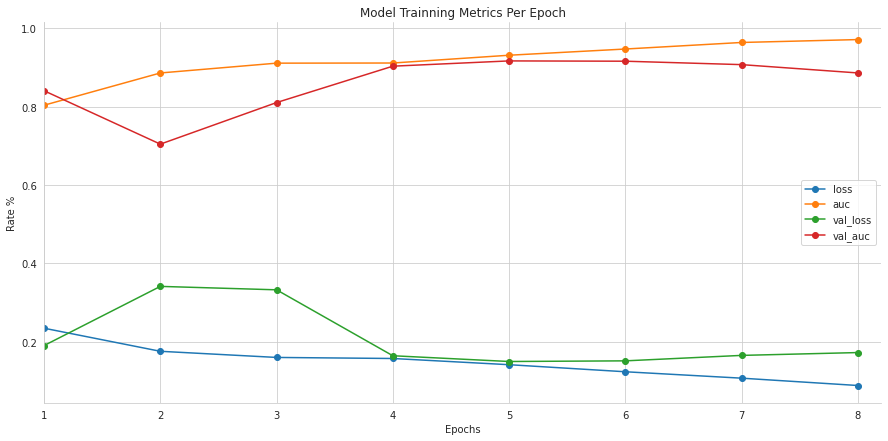

In [19]:
plot_model_history(model.history)

# Save model

In [22]:
model.save(f'/content/gdrive/MyDrive/TheCatheterNinjas/saved_model2/{"InceptionResNetV2_NF_12b_3p_Nadam_0005lr_480"}')


INFO:tensorflow:Assets written to: /content/gdrive/MyDrive/TheCatheterNinjas/saved_model2/InceptionResNetV2_NF_12b_3p_Nadam_0005lr_480/assets


# Zip model and delete

In [ ]:
zipped = '.'.join([MODEL_OUT, 'zip'])
run(['zip', '-r', zipped, MODEL_OUT])
run(['rm', '-r', MODEL_OUT])

CompletedProcess(args=['rm', '-r', 'InceptionResNetV2_16b_5p_nadam_lr0005_400'], returncode=0)